# üìä Marketing Campaign Optimization Project


This is a mock dataset aiming to show how to conduct analysis of marketing campaign effectiveness. The analysis is based on true use cases seen from my work experience as a senior data analyst.

Questions to answer:

    - Which campaign and in which channel performs the best?
    
    - Which segment is highest in the conversion rate?
    
    - Which campaigns and in which channel should we stop or continue to run?
    
    - Which campaigns are the most effective according to t-test versus Bayesian approach?


Structure:

    - EDA
    
    - Data analysis by key attributes: channel, CAMPAIGN_ID, region and segment
        
        - A/B test for conversions
        
        - t-test
         
         -Bayesian
         
         -Segmentation analysis
    


This project analyzes marketing campaign data to:
- Assess data quality
- Perform cohort and causal inference analyses
- Predict conversion success
- Compare campaign effectiveness


In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('marketing_campaign_dataset_large_50k.csv')
df.head()

Campaign_ID        Date       Channel Region   Segment    Spend_USD  \
0   CAMPAIGN_6  2023-08-15         Email  North  Students  3774.642606   
1  CAMPAIGN_10  2023-01-06   Display Ads  North  Students  7610.896365   
2   CAMPAIGN_6  2023-10-16  Social Media   East  Retirees  8938.235614   
3   CAMPAIGN_4  2023-06-11        Search   West  Retirees  2493.890844   
4   CAMPAIGN_6  2023-08-09  Social Media   West  Retirees     0.000000   

    Impressions        Clicks       CTR  Conversions  ... Landing_Page  \
0  40719.495804   6730.806181  0.159643  1127.325682  ...     Homepage   
1  10162.408939      0.000000  0.032450   128.950384  ...  Signup Page   
2  15883.220539   1107.567862  0.078024   252.924939  ...  Signup Page   
3  17877.642767    851.623100  0.037078    24.629184  ...   Promo Page   
4  86503.677046  16754.856152  0.192745  3087.896520  ...     Homepage   

   Gender Group First_Seen_Date Conversion_Rate        CPC        CPA  Week  \
0  Female     B      2023-08-02        0.180817   0.653394   8.036662    33   
1    Male     A      2022-12-22        0.224586  13.710922  61.536526     1   
2   Other     A      2023-10-16        0.205324   0.398849   0.000000    42   
3    Male     B      2023-06-10        0.064244   3.194810  59.600877    23   
4   Other     A      2023-08-09        0.178099   0.122110   0.000000    32   

   Month  Quarter  
0      8        3  
1      1        1  
2     10        4  
3      6        2  
4      8        3  

[5 rows x 23 columns]

In [82]:
# Convert dates and drop unnecessary column
df['Date'] = pd.to_datetime(df['Date'])
df['First_Seen_Date'] = pd.to_datetime(df['First_Seen_Date'])

## 2. Exploratory Data Analysis (EDA)

In [83]:
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Campaign_ID      50000 non-null  object        
 1   Date             50000 non-null  datetime64[ns]
 2   Channel          50000 non-null  object        
 3   Region           50000 non-null  object        
 4   Segment          50000 non-null  object        
 5   Spend_USD        46497 non-null  float64       
 6   Impressions      50000 non-null  float64       
 7   Clicks           50000 non-null  float64       
 8   CTR              46497 non-null  float64       
 9   Conversions      46497 non-null  float64       
 10  User_ID          50000 non-null  object        
 11  Device           50000 non-null  object        
 12  Source           50000 non-null  object        
 13  Landing_Page     50000 non-null  object        
 14  Gender           50000 non-null  objec

In [84]:
# Missing values
print("\n Missing values by column:\n")
print(df.isnull().sum())

# Unique categorial values by attributes
categorical_cols = df.select_dtypes(include='object').columns
print("\n Uniq values by attributes:")
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")


 Missing values by column:

Campaign_ID           0
Date                  0
Channel               0
Region                0
Segment               0
Spend_USD          3503
Impressions           0
Clicks                0
CTR                3503
Conversions        3503
User_ID               0
Device                0
Source                0
Landing_Page          0
Gender                0
Group                 0
First_Seen_Date       0
Conversion_Rate       0
CPC                   0
CPA                   0
Week                  0
Month                 0
Quarter               0
dtype: int64

 Uniq values by attributes:
Campaign_ID: 10 unique values
Channel: 6 unique values
Region: 4 unique values
Segment: 5 unique values
User_ID: 500 unique values
Device: 3 unique values
Source: 3 unique values
Landing_Page: 3 unique values
Gender: 3 unique values
Group: 2 unique values


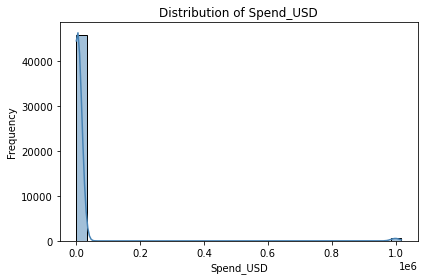

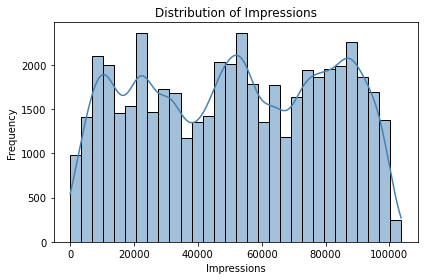

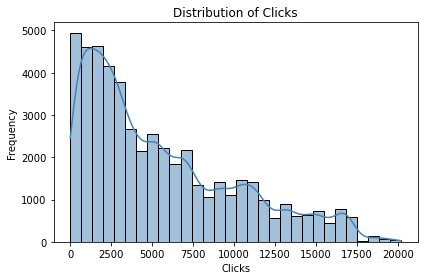

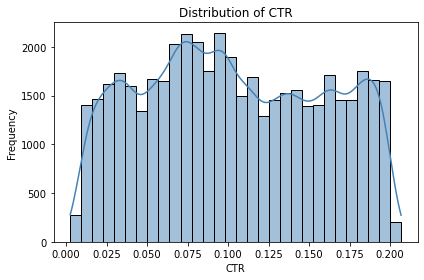

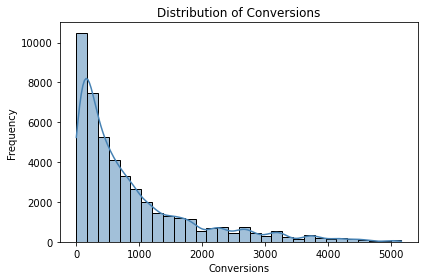

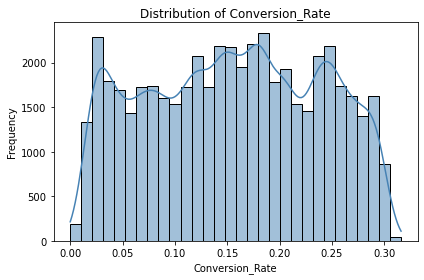

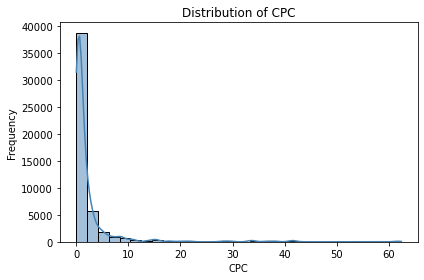

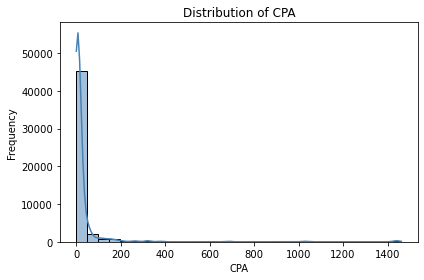

In [85]:
# ----------------------------
# 1. Distribution of Numerical Features
# ----------------------------
numerical_features = [
    'Spend_USD', 'Impressions', 'Clicks', 'CTR',
    'Conversions', 'Conversion_Rate', 'CPC', 'CPA'
]

for feature in numerical_features:
    plt.figure()
    sns.histplot(df[feature], kde=True, bins=30, color='steelblue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()


Outlier Summary (based on IQR method):
                 outliers_count   lower_bound    upper_bound
CPA                      5626.0    -21.745007      39.949413
CPC                      5461.0     -2.052125       4.195327
Conversions              3480.0  -1262.116442    2622.171399
Spend_USD                 787.0 -10718.813554   17864.689256
Clicks                    253.0  -8054.409508   18152.199596
Impressions                 0.0 -52487.643760  155418.801405
CTR                         0.0     -0.078714       0.288548
Conversion_Rate             0.0     -0.123293       0.434855
Week                        0.0    -25.000000      79.000000
Month                       0.0     -5.000000      19.000000
Quarter                     0.0     -1.000000       7.000000


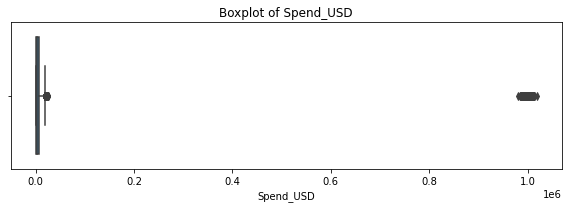

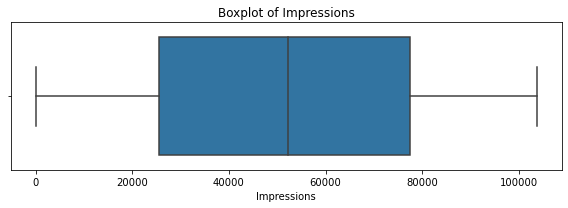

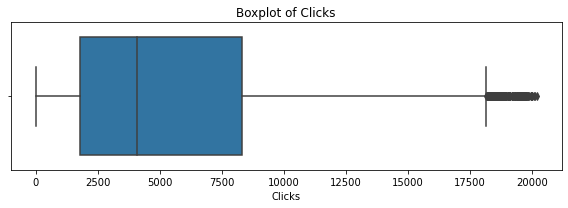

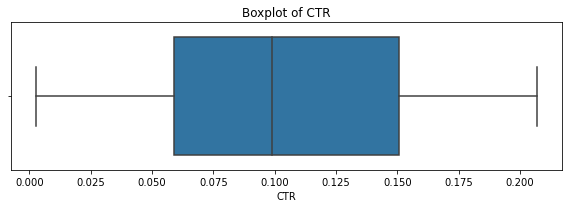

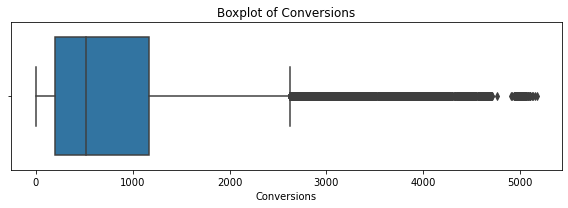

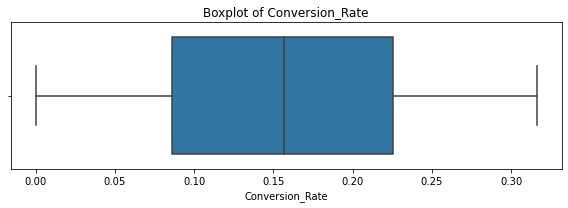

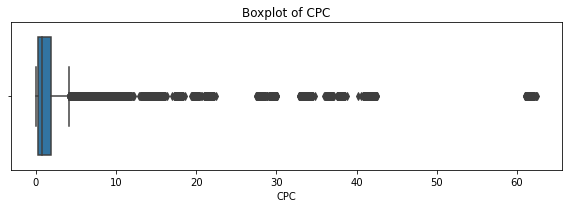

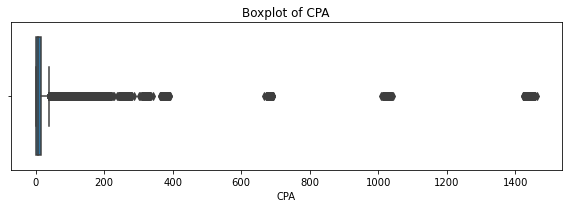

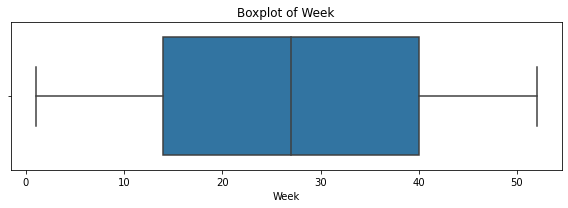

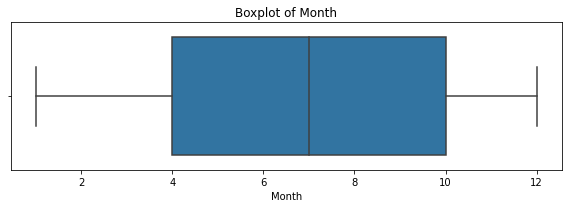

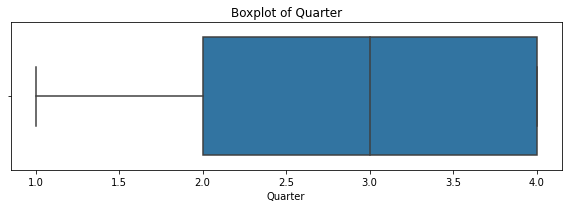

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Select numerical columns
numeric_cols = df.select_dtypes(include='number').columns

# Step 2: Detect outliers using IQR method
outlier_summary = {}

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    
    outlier_summary[col] = {
        "outliers_count": len(outliers),
        "lower_bound": lower_bound,
        "upper_bound": upper_bound
    }

# Step 3: Display the summary
outlier_df = pd.DataFrame(outlier_summary).T.sort_values(by="outliers_count", ascending=False)
print("Outlier Summary (based on IQR method):")
print(outlier_df)

# Step 4: Optional visualization
for col in numeric_cols:
    plt.figure(figsize=(8, 3))
    sns.boxplot(data=df, x=col)
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()


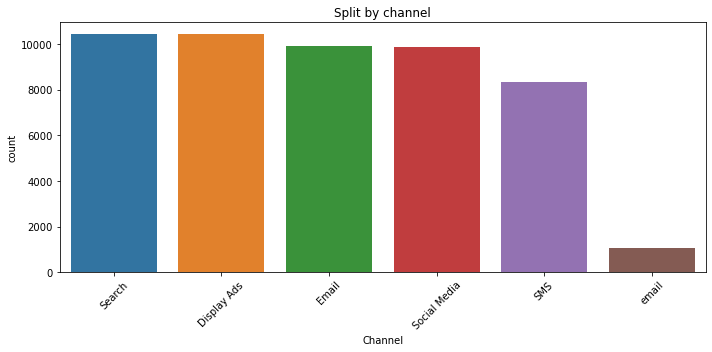

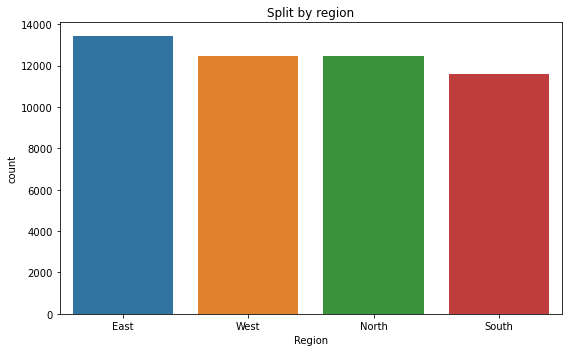

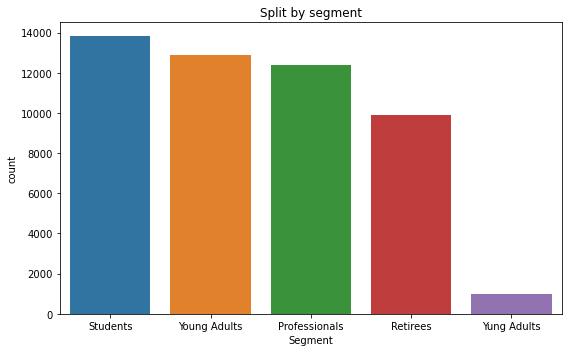

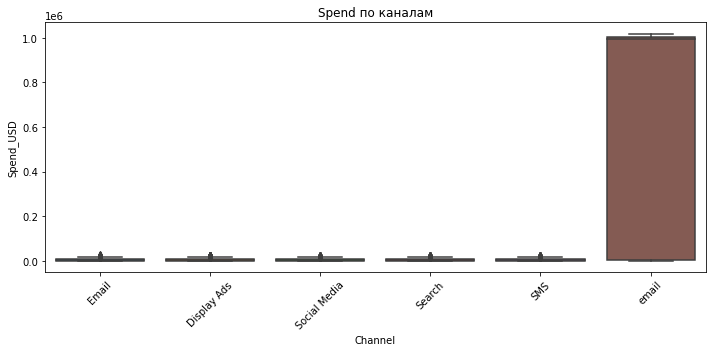

In [87]:
# –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ø–æ –∫–∞–Ω–∞–ª–∞–º
plt.figure(figsize=(10, 5))
sns.countplot(x='Channel', data=df, order=df['Channel'].value_counts().index)
plt.title('Split by channel')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ø–æ —Ä–µ–≥–∏–æ–Ω–∞–º
plt.figure(figsize=(8, 5))
sns.countplot(x='Region', data=df, order=df['Region'].value_counts().index)
plt.title('Split by region')
plt.tight_layout()
plt.show()

# –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ø–æ —Å–µ–≥–º–µ–Ω—Ç–∞–º
plt.figure(figsize=(8, 5))
sns.countplot(x='Segment', data=df, order=df['Segment'].value_counts().index)
plt.title('Split by segment')
plt.tight_layout()
plt.show()

# Boxplot –ø–æ Spend_USD
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='Channel', y='Spend_USD')
plt.title('Spend –ø–æ –∫–∞–Ω–∞–ª–∞–º')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


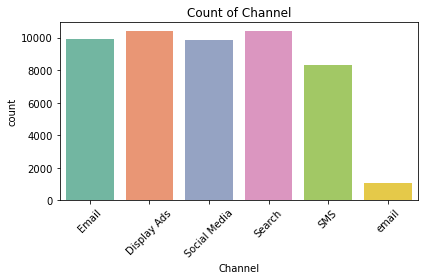

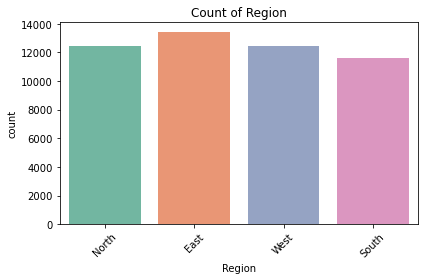

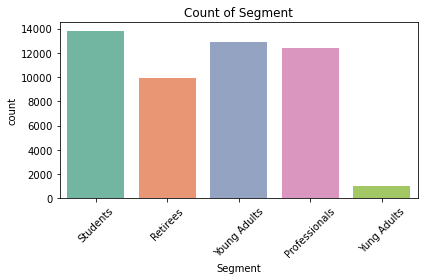

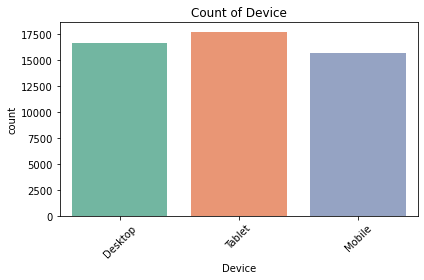

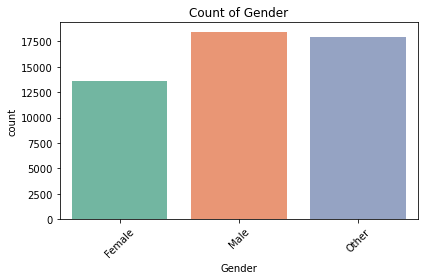

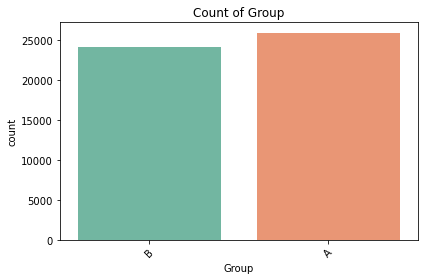

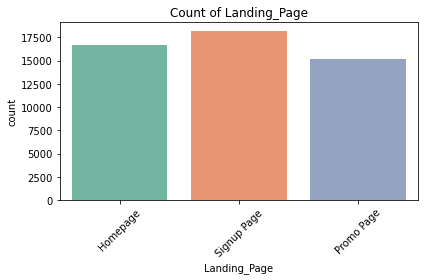

In [88]:
# ----------------------------
# 2. Count Plots for Categorical Features
# ----------------------------
categorical_features = [
    'Channel', 'Region', 'Segment', 'Device',
    'Gender', 'Group', 'Landing_Page'
]

for feature in categorical_features:
    plt.figure()
    sns.countplot(data=df, x=feature, palette='Set2')
    plt.title(f'Count of {feature}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


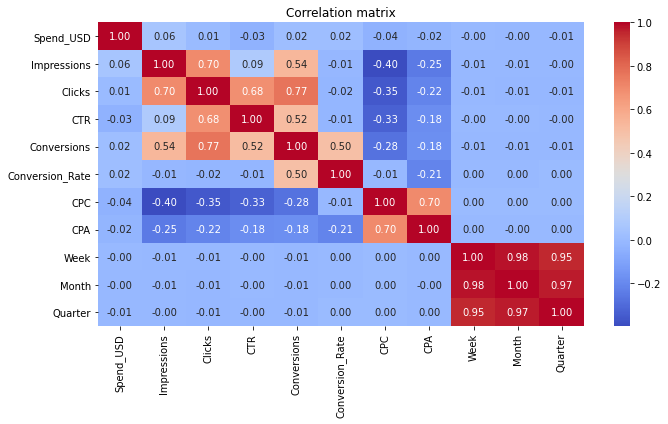

In [91]:
# Pairplot 
# sns.pairplot(df[['Spend_USD', 'Impressions', 'Clicks', 'Conversions', 'CTR', 'Conversion_Rate']])

import matplotlib.pyplot as plt
import seaborn as sns

numeric_df = df.select_dtypes(include=['number'])

plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation matrix')
plt.tight_layout()
plt.show()

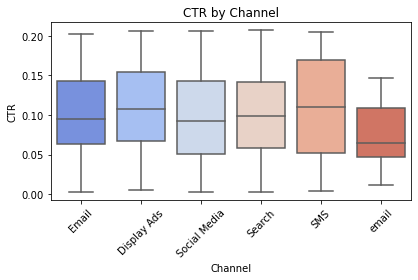

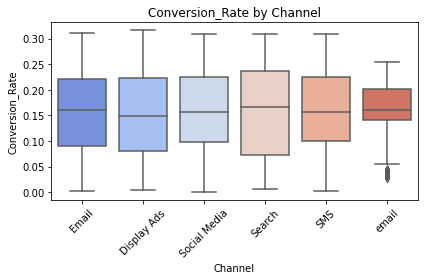

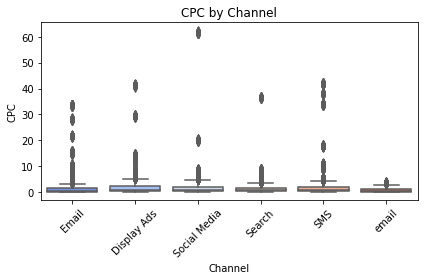

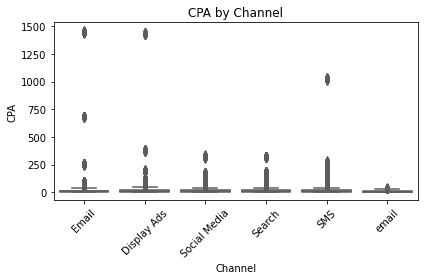

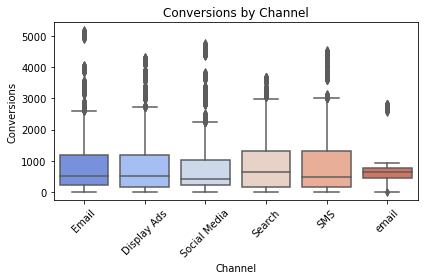

In [92]:
# ----------------------------
# 3. Box Plots of Performance Metrics by Channel
# ----------------------------
performance_metrics = ['CTR', 'Conversion_Rate', 'CPC', 'CPA','Conversions']

for metric in performance_metrics:
    plt.figure()
    sns.boxplot(data=df, x='Channel', y=metric, palette='coolwarm')
    plt.title(f'{metric} by Channel')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 3. Data Cleaning

# 3.1. Handling missing values

In [93]:
# Display number of missing values per column before imputation
print("Missing values before imputation:")
print(df.isnull().sum())

# Select only numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns

# Impute missing values in numeric columns with the column mean
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Display number of missing values per column after imputation
print("\nMissing values after imputation:")
print(df.isnull().sum())

Missing values before imputation:
Campaign_ID           0
Date                  0
Channel               0
Region                0
Segment               0
Spend_USD          3503
Impressions           0
Clicks                0
CTR                3503
Conversions        3503
User_ID               0
Device                0
Source                0
Landing_Page          0
Gender                0
Group                 0
First_Seen_Date       0
Conversion_Rate       0
CPC                   0
CPA                   0
Week                  0
Month                 0
Quarter               0
dtype: int64

Missing values after imputation:
Campaign_ID        0
Date               0
Channel            0
Region             0
Segment            0
Spend_USD          0
Impressions        0
Clicks             0
CTR                0
Conversions        0
User_ID            0
Device             0
Source             0
Landing_Page       0
Gender             0
Group              0
First_Seen_Date    0
Conversion

# 3.2. Outliers

In [94]:

# Step 1: Define time-related columns to exclude
time_columns = ['Date', 'Activity_Date', 'Activity_Month', 'Cohort_Month']
df_fixed = df.copy()

# Step 2: Select numeric columns excluding time variables
numeric_cols = df_fixed.drop(columns=[col for col in time_columns if col in df_fixed.columns], errors='ignore')
numeric_cols = numeric_cols.select_dtypes(include='number').columns

# Step 3: Cap outliers using IQR method
for col in numeric_cols:
    Q1 = df_fixed[col].quantile(0.25)
    Q3 = df_fixed[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Winsorization (Capping)
    df_fixed[col] = df_fixed[col].clip(lower=lower_bound, upper=upper_bound)

print("Outliers capped using IQR method.")


Outliers capped using IQR method.


Outlier Count Per Numeric Column (Excluding Time):
Column                       Before     After
---------------------------------------------
Spend_USD                       612         0
Impressions                       0         0
Clicks                          253         0
CTR                               0         0
Conversions                    4083         0
Conversion_Rate                   0         0
CPC                            5461         0
CPA                            5626         0


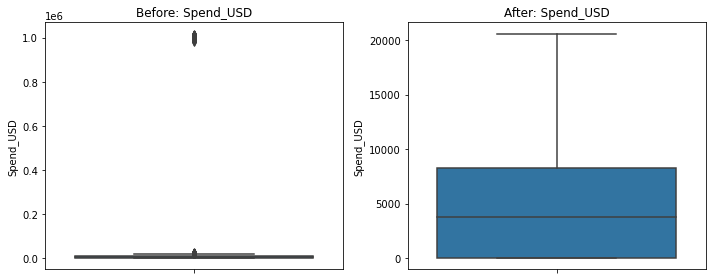

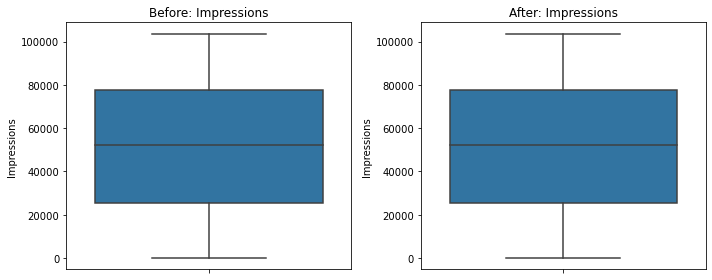

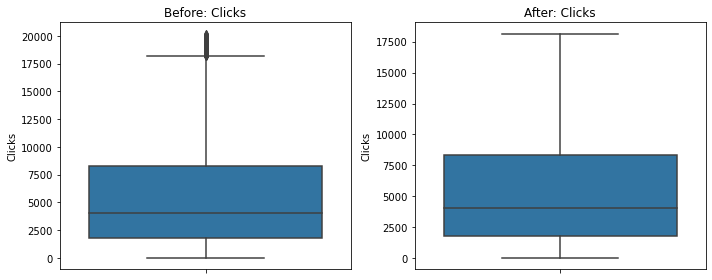

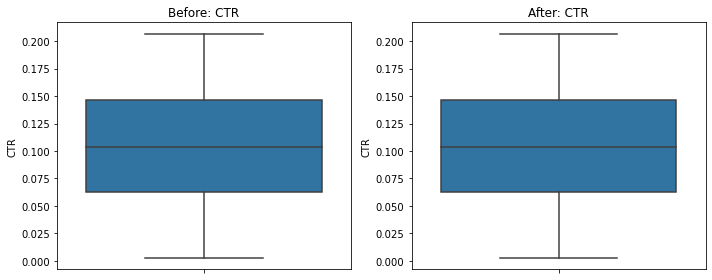

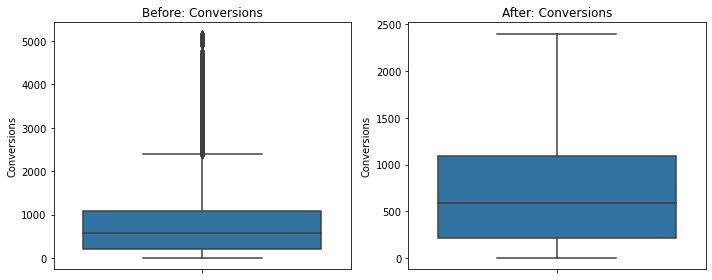

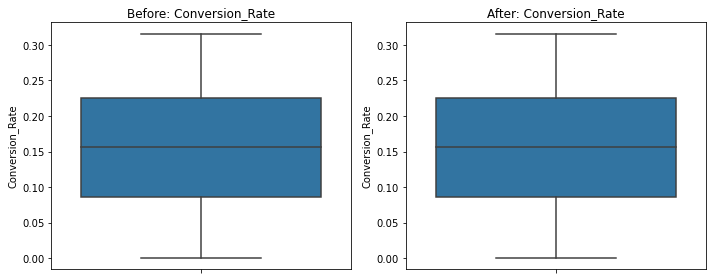

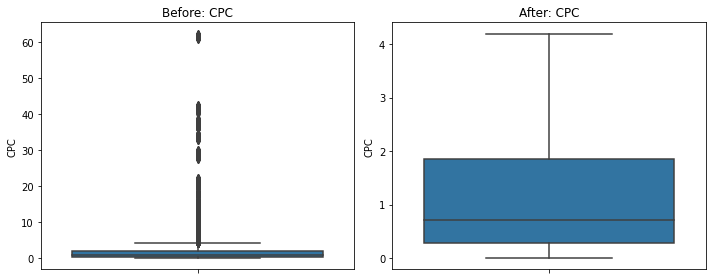

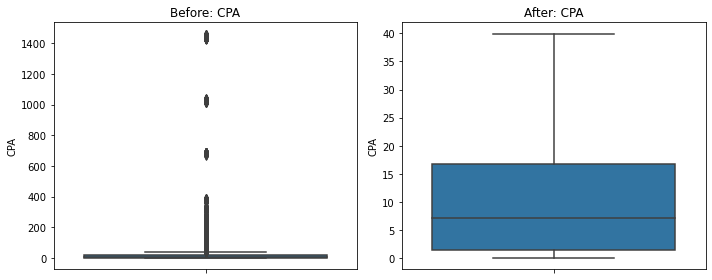

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define time columns to exclude
time_columns = ['Date', 'Activity_Date', 'Activity_Month', 'Cohort_Month', 'Month', 'Week', 'Quarter']

# Select only numeric columns excluding time
numeric_cols = df_fixed.select_dtypes(include='number').columns
numeric_cols = [col for col in numeric_cols if col not in time_columns]

# Helper function to detect IQR-based outliers
def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((series < lower_bound) | (series > upper_bound)).sum()

# Print comparison of outlier counts before and after fixing
print("Outlier Count Per Numeric Column (Excluding Time):")
print(f"{'Column':<25}{'Before':>10}{'After':>10}")
print("-" * 45)
for col in numeric_cols:
    before = detect_outliers_iqr(df[col])
    after = detect_outliers_iqr(df_fixed[col])
    print(f"{col:<25}{before:>10}{after:>10}")

# Optional: visualize before and after using boxplots
for col in numeric_cols:
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    sns.boxplot(y=df[col])
    plt.title(f"Before: {col}")

    plt.subplot(1, 2, 2)
    sns.boxplot(y=df_fixed[col])
    plt.title(f"After: {col}")

    plt.tight_layout()
    plt.show()


# 3.3. Fixing mispelled segment name

In [96]:
print("Before correction:", df_fixed['Segment'].unique())

# Correct the misspelled value
df_fixed['Segment'] = df_fixed['Segment'].replace('Yung Adults', 'Young Adults')

# Verify correction
print("After correction:", df_fixed['Segment'].unique())


Before correction: ['Students' 'Retirees' 'Young Adults' 'Professionals' 'Yung Adults']
After correction: ['Students' 'Retirees' 'Young Adults' 'Professionals']


In [97]:
print("Before correction:", df_fixed['Channel'].unique())

# Correct the misspelled value
df_fixed['Channel'] = df_fixed['Channel'].replace('email', 'Email')

# Verify correction
print("After correction:", df_fixed['Channel'].unique())


Before correction: ['Email' 'Display Ads' 'Social Media' 'Search' 'SMS' 'email']
After correction: ['Email' 'Display Ads' 'Social Media' 'Search' 'SMS']


# Cohort analysis

In [98]:
# Group by user to get user-level data
user_level_df = df_fixed.groupby('User_ID').agg({
    'Campaign_ID': 'first',
    'Date': 'min',  # Earliest activity date
    'Channel': 'first',
    'Region': 'first',
    'Segment': 'first',
    'Spend_USD': 'sum',
    'Impressions': 'sum',
    'Clicks': 'sum',
    'CTR': 'mean',
    'Conversions': 'sum',
    'Device': 'first',
    'Source': 'first',
    'Landing_Page': 'first',
    'Gender': 'first',
    'Group': 'first',
    'First_Seen_Date': 'min',
    'Conversion_Rate': 'mean',
    'CPC': 'mean',
    'CPA': 'mean',
    'Week': 'min',
    'Month': 'min',
    'Quarter': 'min'
}).reset_index()





In [99]:
user_level_df.head()

User_ID Campaign_ID       Date       Channel  \
0  002962bd-a415-4d66-b7f3-46c42beb215a  CAMPAIGN_4 2023-01-01        Search   
1  002a4985-3dfc-418b-9edb-6badab7ec70a  CAMPAIGN_9 2023-01-04         Email   
2  0039ab95-b3f3-46b5-96fa-478e725d5001  CAMPAIGN_8 2023-01-01  Social Media   
3  006ff2b4-f13d-46f6-bb0d-4f079ec60d03  CAMPAIGN_6 2023-01-01           SMS   
4  00d755c8-5d4a-48ca-81b5-e1ab853c6cee  CAMPAIGN_1 2023-01-03  Social Media   

  Region        Segment      Spend_USD   Impressions        Clicks       CTR  \
0  North   Young Adults  252394.370124  9.459608e+05  3.017654e+04  0.035354   
1   East   Young Adults  422960.738554  7.819288e+06  1.097866e+06  0.139521   
2  North   Young Adults  243092.337566  9.288576e+06  3.209879e+05  0.034653   
3  North  Professionals  550613.281911  3.048184e+06  4.901897e+05  0.159934   
4   West  Professionals  513658.959261  5.959597e+06  9.539105e+05  0.159897   

   ...  Landing_Page  Gender Group First_Seen_Date Conversion_Rate       CPC  \
0  ...      Homepage    Male     B      2022-12-10        0.073836  3.571210   
1  ...      Homepage    Male     A      2022-12-15        0.229135  0.351994   
2  ...   Signup Page  Female     B      2022-12-17        0.185725  0.297686   
3  ...    Promo Page  Female     A      2022-12-14        0.017070  0.921570   
4  ...   Signup Page   Other     A      2022-12-26        0.121334  0.535722   

         CPA  Week  Month  Quarter  
0  39.895241     1      1        1  
1   3.208764     1      1        1  
2   2.917416     1      1        1  
3  39.917787     1      1        1  
4   5.268298     1      1        1  

[5 rows x 23 columns]

In [100]:
user_level_df['Activity_Date'] = pd.to_datetime(user_level_df['First_Seen_Date'])  # if not datetime yet
user_level_df['Activity_Month'] = user_level_df['First_Seen_Date'].dt.to_period('M')


In [101]:
# If you have an 'Activity_Month' as a datetime or period representing user activity month

# Step 1: Find first activity month (cohort month) for each user
user_first_month = user_level_df.groupby('User_ID')['Activity_Month'].min().reset_index()
user_first_month.rename(columns={'Activity_Month': 'Cohort_Month'}, inplace=True)

# Step 2: Merge back to original df to assign each user‚Äôs cohort month
user_level_df = user_level_df.merge(user_first_month, on='User_ID', how='left')


In [102]:
user_level_df.head()

User_ID Campaign_ID       Date       Channel  \
0  002962bd-a415-4d66-b7f3-46c42beb215a  CAMPAIGN_4 2023-01-01        Search   
1  002a4985-3dfc-418b-9edb-6badab7ec70a  CAMPAIGN_9 2023-01-04         Email   
2  0039ab95-b3f3-46b5-96fa-478e725d5001  CAMPAIGN_8 2023-01-01  Social Media   
3  006ff2b4-f13d-46f6-bb0d-4f079ec60d03  CAMPAIGN_6 2023-01-01           SMS   
4  00d755c8-5d4a-48ca-81b5-e1ab853c6cee  CAMPAIGN_1 2023-01-03  Social Media   

  Region        Segment      Spend_USD   Impressions        Clicks       CTR  \
0  North   Young Adults  252394.370124  9.459608e+05  3.017654e+04  0.035354   
1   East   Young Adults  422960.738554  7.819288e+06  1.097866e+06  0.139521   
2  North   Young Adults  243092.337566  9.288576e+06  3.209879e+05  0.034653   
3  North  Professionals  550613.281911  3.048184e+06  4.901897e+05  0.159934   
4   West  Professionals  513658.959261  5.959597e+06  9.539105e+05  0.159897   

   ...  First_Seen_Date Conversion_Rate       CPC        CPA Week Month  \
0  ...       2022-12-10        0.073836  3.571210  39.895241    1     1   
1  ...       2022-12-15        0.229135  0.351994   3.208764    1     1   
2  ...       2022-12-17        0.185725  0.297686   2.917416    1     1   
3  ...       2022-12-14        0.017070  0.921570  39.917787    1     1   
4  ...       2022-12-26        0.121334  0.535722   5.268298    1     1   

  Quarter  Activity_Date  Activity_Month  Cohort_Month  
0       1     2022-12-10         2022-12       2022-12  
1       1     2022-12-15         2022-12       2022-12  
2       1     2022-12-17         2022-12       2022-12  
3       1     2022-12-14         2022-12       2022-12  
4       1     2022-12-26         2022-12       2022-12  

[5 rows x 26 columns]

In [103]:
# import pandas as pd
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import NearestNeighbors
# from sklearn.preprocessing import OneHotEncoder

# # Define the outcome variable
# outcome = 'Spend_USD'

# # Covariates to match on
# covariates = ['Region', 'Segment', 'Channel']

# # One-hot encode categorical covariates once
# df_encoded = pd.get_dummies(df[covariates], drop_first=True)
# X_all = df_encoded

# # Store results
# att_results = []

# # Loop through all campaigns
# for i in range(1, 10):
#     campaign_id = f'CAMPAIGN_{i}'
    
#     df_copy = df.copy()
#     df_copy['Treatment'] = (df_copy['Campaign_ID'] == campaign_id).astype(int)

#     # Outcome vector
#     y = df_copy['Treatment']
    
#     # Refit logistic regression for this campaign
#     logit = LogisticRegression(max_iter=1000)
#     logit.fit(X_all, y)
    
#     # Add propensity scores
#     df_copy['propensity_score'] = logit.predict_proba(X_all)[:, 1]

#     # Split treated and control
#     treated = df_copy[df_copy['Treatment'] == 1]
#     control = df_copy[df_copy['Treatment'] == 0]
    
#     if treated.empty or control.empty:
#         att_results.append({'Campaign_ID': campaign_id, 'ATT': None, 'Note': 'No treated or control samples'})
#         continue

#     # Nearest neighbor matching
#     nn = NearestNeighbors(n_neighbors=1)
#     nn.fit(control[['propensity_score']])
    
#     distances, indices = nn.kneighbors(treated[['propensity_score']])
#     matched_control = control.iloc[indices.flatten()].copy()

#     # Calculate ATT
#     att = (treated[outcome].values - matched_control[outcome].values).mean()
#     att_results.append({'Campaign_ID': campaign_id, 'ATT': att, 'Note': 'OK'})

# # Convert results to DataFrame
# att_df = pd.DataFrame(att_results)

# # Show the results
# print(att_df)


## 3. A/B Testing (CTR & Conversions by Channel)

In [104]:
import pandas as pd
from scipy.stats import ttest_ind
from itertools import combinations

# Unique channels and segments
channels = df_fixed['Channel'].unique()
segments = df_fixed['Segment'].unique()

# Store results
results = []

# Loop through all segments and all unique channel pairs
for segment in segments:
    segment_data = df_fixed[df_fixed['Segment'] == segment]
    
    for ch1, ch2 in combinations(channels, 2):
        grp1 = segment_data[segment_data['Channel'] == ch1]['CTR']
        grp2 = segment_data[segment_data['Channel'] == ch2]['CTR']

        if len(grp1) > 1 and len(grp2) > 1:
            t_stat, p_val = ttest_ind(grp1, grp2, equal_var=False)
        else:
            t_stat, p_val = None, None

        results.append({
            'Segment': segment,
            'Channel_1': ch1,
            'Channel_2': ch2,
            'Channel_1_mean_CTR': grp1.mean() if len(grp1) > 0 else None,
            'Channel_2_mean_CTR': grp2.mean() if len(grp2) > 0 else None,
            'n1': len(grp1),
            'n2': len(grp2),
            't_stat': t_stat,
            'p_value': p_val
        })

# Compile results into DataFrame
results_df = pd.DataFrame(results)

# Bonferroni correction for multiple testing
alpha = 0.05
results_df['p_adj'] = results_df['p_value'] * len(results_df)
results_df['Significant'] = results_df['p_adj'] < alpha

# Display results sorted by significance
results_df_sorted = results_df.sort_values(by='p_adj')
print(results_df_sorted[['Segment', 'Channel_1', 'Channel_2', 'Channel_1_mean_CTR', 'Channel_2_mean_CTR', 'p_value', 'p_adj', 'Significant']])


          Segment     Channel_1     Channel_2  Channel_1_mean_CTR  \
38  Professionals  Social Media           SMS            0.095446   
0        Students         Email   Display Ads            0.087131   
25   Young Adults   Display Ads        Search            0.118614   
34  Professionals   Display Ads  Social Media            0.115853   
33  Professionals         Email           SMS            0.103258   
18       Retirees  Social Media           SMS            0.092979   
39  Professionals        Search           SMS            0.106989   
20   Young Adults         Email   Display Ads            0.102101   
16       Retirees   Display Ads           SMS            0.097702   
26   Young Adults   Display Ads           SMS            0.118614   
27   Young Adults  Social Media        Search            0.106038   
5        Students   Display Ads        Search            0.110342   
13       Retirees         Email           SMS            0.099296   
30  Professionals         Email   

# 4.Bayesian A/B testing

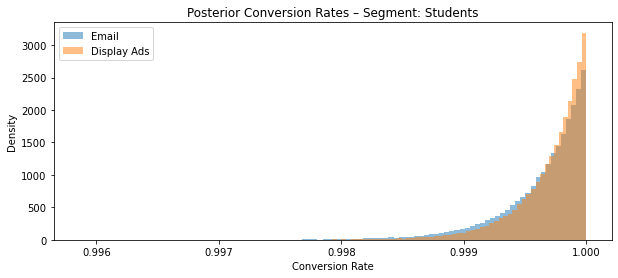

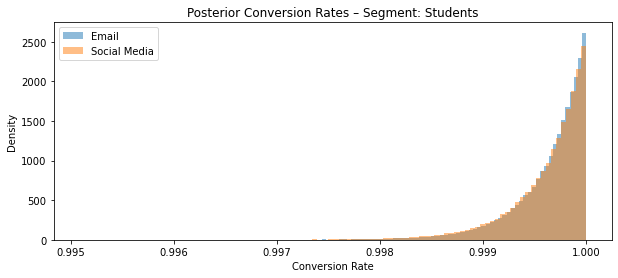

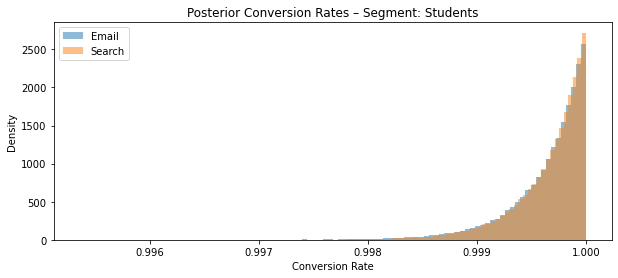

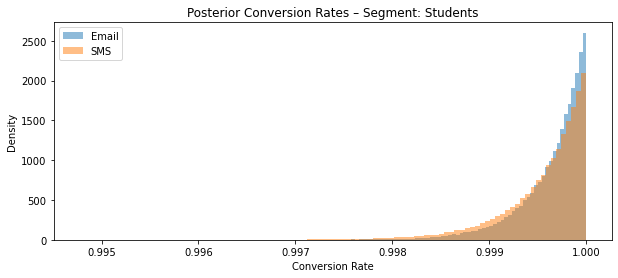

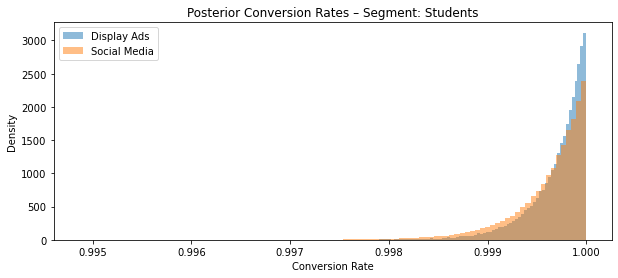

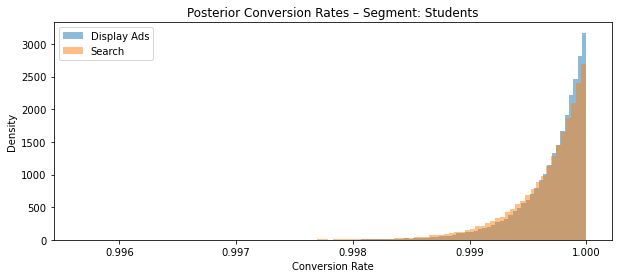

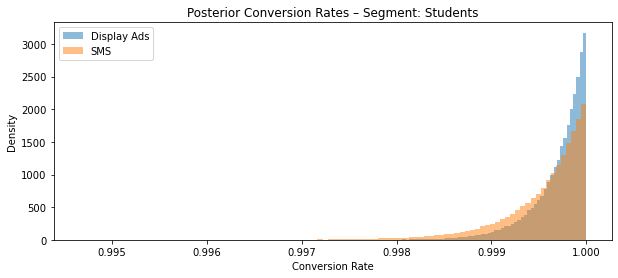

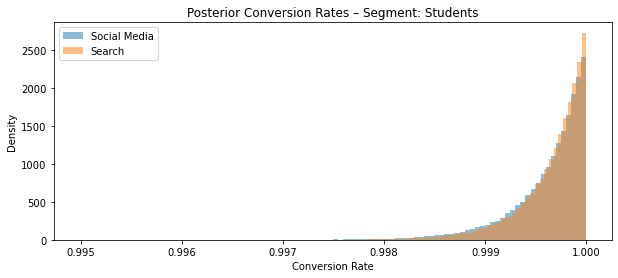

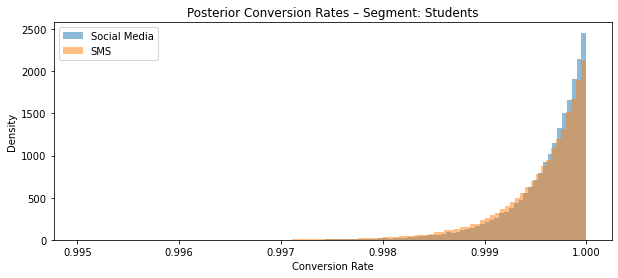

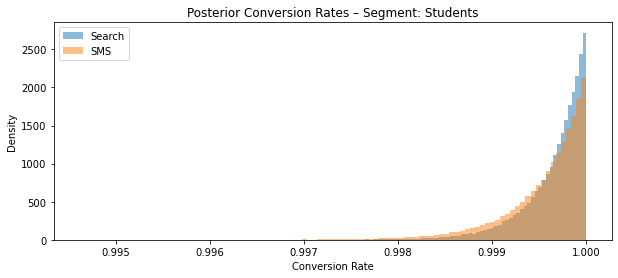

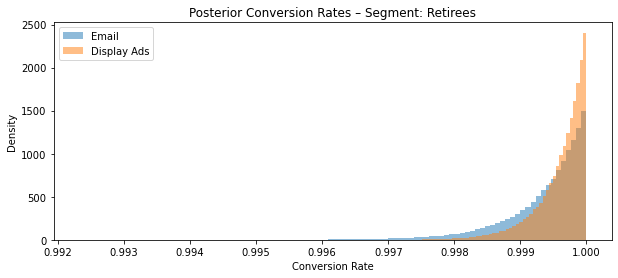

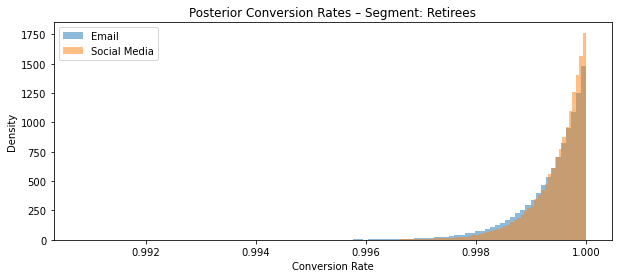

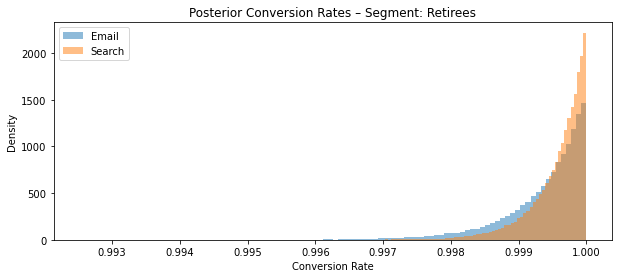

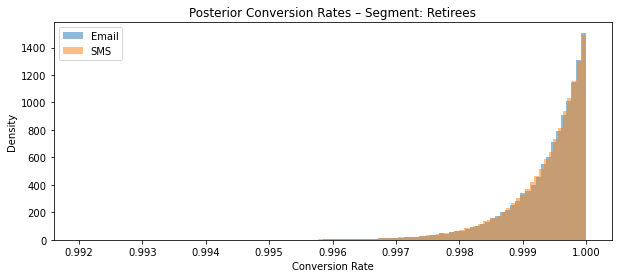

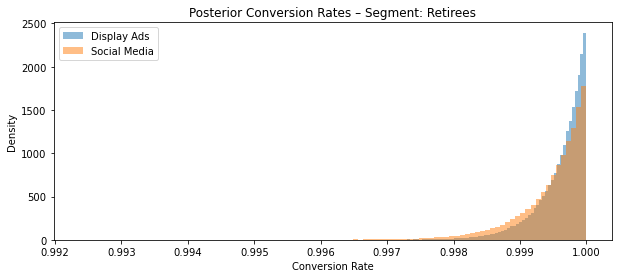

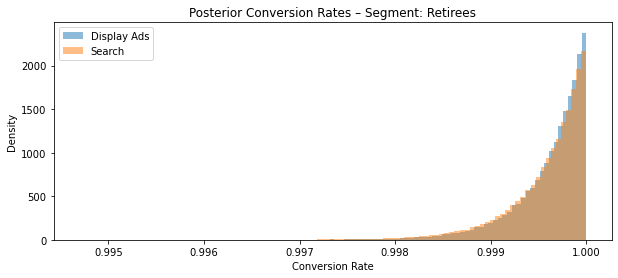

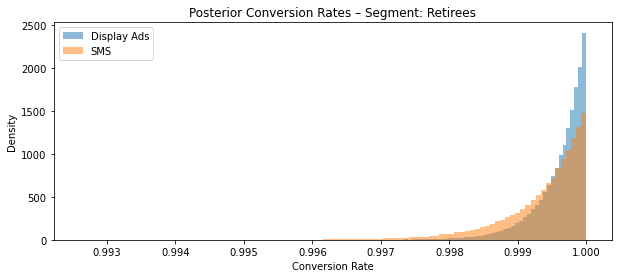

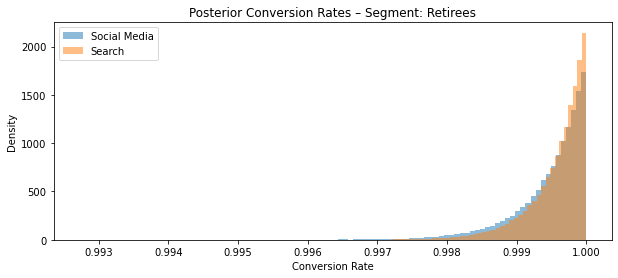

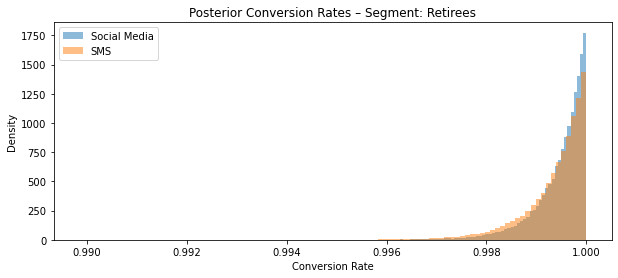

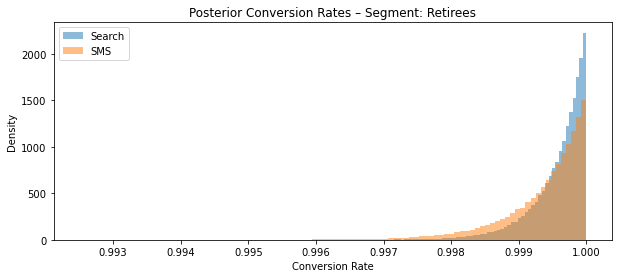

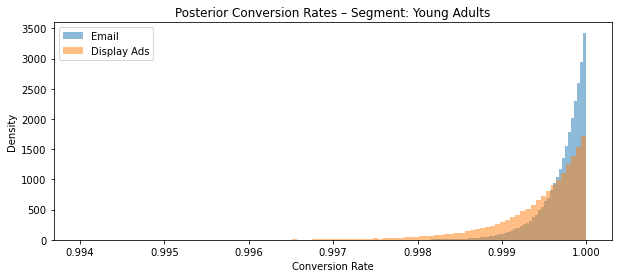

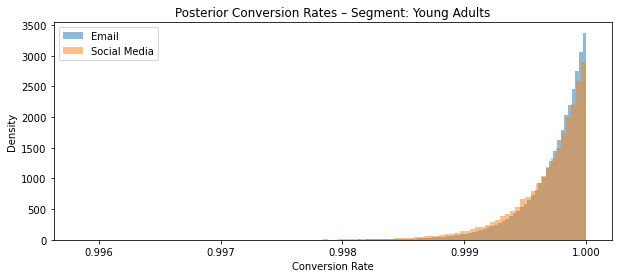

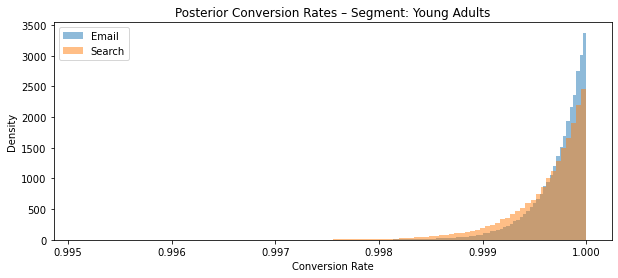

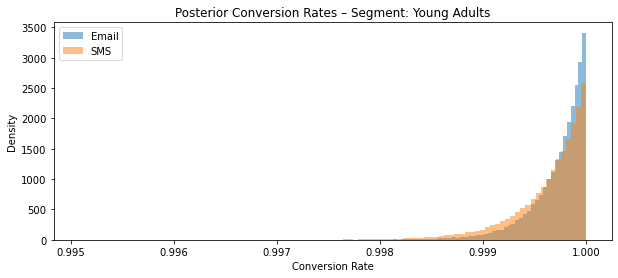

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta
from itertools import combinations

# Settings
segment_col = 'Segment'
outcome_col = 'Conversion_Rate'  # You can switch to 'CTR' if needed
channels = df_fixed['Channel'].unique()
segments = df_fixed[segment_col].unique()

# Priors for Beta distribution
alpha_prior, beta_prior = 1, 1

# Store results
bayes_results = []

# Loop over each segment
for segment in segments:
    seg_df = df_fixed[df_fixed[segment_col] == segment]
    
    for ch1, ch2 in combinations(channels, 2):
        grp1 = seg_df[seg_df['Channel'] == ch1]
        grp2 = seg_df[seg_df['Channel'] == ch2]

        conversions_1 = (grp1[outcome_col] > 0).sum()
        trials_1 = len(grp1)
        conversions_2 = (grp2[outcome_col] > 0).sum()
        trials_2 = len(grp2)

        if trials_1 < 10 or trials_2 < 10:
            bayes_results.append({
                'Segment': segment,
                'Channel_1': ch1,
                'Channel_2': ch2,
                'Note': 'Too few samples',
                'Prob_2_Better (%)': None,
                'Mean Lift (%)': None
            })
            continue

        # Posteriors
        post_1 = beta(alpha_prior + conversions_1, beta_prior + trials_1 - conversions_1)
        post_2 = beta(alpha_prior + conversions_2, beta_prior + trials_2 - conversions_2)

        samples_1 = post_1.rvs(100000)
        samples_2 = post_2.rvs(100000)

        prob_2_better = np.mean(samples_2 > samples_1)
        lift = (samples_2 - samples_1) / samples_1

        bayes_results.append({
            'Segment': segment,
            'Channel_1': ch1,
            'Channel_2': ch2,
            'Prob_2_Better (%)': round(prob_2_better * 100, 2),
            'Mean Lift (%)': round(np.mean(lift) * 100, 2),
            'Note': 'OK'
        })

        # Optional: Plot posterior distributions
        plt.figure(figsize=(10, 4))
        plt.hist(samples_1, bins=100, alpha=0.5, label=f"{ch1}", density=True)
        plt.hist(samples_2, bins=100, alpha=0.5, label=f"{ch2}", density=True)
        plt.title(f"Posterior Conversion Rates ‚Äì Segment: {segment}")
        plt.xlabel("Conversion Rate")
        plt.ylabel("Density")
        plt.legend()
        plt.show()

# Results to DataFrame
bayes_results_df = pd.DataFrame(bayes_results)
print(bayes_results_df)


# Causal inference 

In [34]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

# Replace with your actual DataFrame
# df_fixed = pd.read_csv("your_data.csv")

# Outcome variable (can be changed as needed)
outcome = 'Spend_USD'

# Covariates to use for propensity score modeling
covariates = ['Region', 'Segment', 'Channel']

# Prepare to store results
results = []

# Loop through CAMPAIGN_1 to CAMPAIGN_9
for i in range(1, 10):
    campaign_id = f'CAMPAIGN_{i}'
    df_fixed_temp = df_fixed.copy()

    # Define treatment
    df_fixed_temp['Treatment'] = (df_fixed_temp['Campaign_ID'] == campaign_id).astype(int)

    # One-hot encode covariates
    df_fixed_encoded = pd.get_dummies(df_fixed_temp[covariates], drop_first=True)
    X = df_fixed_encoded
    y = df_fixed_temp['Treatment']

    # Skip if not enough treated or control samples
    if y.sum() < 10 or (y == 0).sum() < 10:
        results.append({
            'Campaign': campaign_id,
            'ATT': None,
            'Note': 'Too few samples'
        })
        continue

    # Fit logistic regression for propensity score
    logit = LogisticRegression(max_iter=1000)
    logit.fit(X, y)
    df_fixed_temp['propensity_score'] = logit.predict_proba(X)[:, 1]

    # Split treated and control
    treated = df_fixed_temp[df_fixed_temp['Treatment'] == 1]
    control = df_fixed_temp[df_fixed_temp['Treatment'] == 0]

    # Nearest neighbor matching
    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(control[['propensity_score']])
    distances, indices = nn.kneighbors(treated[['propensity_score']])
    matched_control = control.iloc[indices.flatten()]

    # Compute ATT
    att = (treated[outcome].values - matched_control[outcome].values).mean()

    results.append({
        'Campaign': campaign_id,
        'ATT': round(att, 2),
        'Note': 'OK'
    })

# Convert to DataFrame and show results
results_df_fixed = pd.DataFrame(results)
print(results_df_fixed)


/hdd/bigdata/python_envs/external/external/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/hdd/bigdata/python_envs/external/external/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/hdd/bigdata/python_envs/external/external/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/hdd/bigdata/python_envs/external/external/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/hdd/bigdata/python_envs/external/external/lib/python3.7/site-pa

     Campaign      ATT Note
0  CAMPAIGN_1 -1150.07   OK
1  CAMPAIGN_2   779.71   OK
2  CAMPAIGN_3  1148.21   OK
3  CAMPAIGN_4 -1159.21   OK
4  CAMPAIGN_5   199.93   OK
5  CAMPAIGN_6  -863.44   OK
6  CAMPAIGN_7  -270.88   OK
7  CAMPAIGN_8   -34.43   OK
8  CAMPAIGN_9   237.39   OK


# 4. Predictive Modeling

We need to first define target variable. In our case it's conversions.

In [35]:
df_fixed['High_Conversion'] = (df_fixed['Conversions'] > df_fixed['Conversions'].median()).astype(int)

Let's split data to training and testing datasets

In [37]:
from sklearn.model_selection import train_test_split

# Feature selection
features = ['Channel', 'Region', 'Segment', 'Spend_USD', 'CTR', 'Impressions', 'Clicks']
X = pd.get_dummies(df[features], drop_first=True)
y = df_fixed['High_Conversion']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


Then, we will build simple baseline logistic regression model.

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Train baseline model
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
log_preds = log_model.predict(X_test)

# Evaluation
print("Logistic Regression Report:")
print(classification_report(y_test, log_preds))
print("ROC-AUC:", roc_auc_score(y_test, log_model.predict_proba(X_test)[:, 1]))


Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.75      0.51      0.60      5000
           1       0.63      0.83      0.71      5000

    accuracy                           0.67     10000
   macro avg       0.69      0.67      0.66     10000
weighted avg       0.69      0.67      0.66     10000

ROC-AUC: 0.7909524800000001


/hdd/bigdata/python_envs/external/external/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Create binary target: High Conversion (above median)
df_fixed['High_Conversion'] = (df_fixed['Conversions'] > df_fixed['Conversions'].median()).astype(int)

# Features: One-hot encode categorical variables
X = pd.get_dummies(df_fixed[['Channel', 'Region', 'Segment']], drop_first=True)

# Add numerical features
X['Spend_USD'] = df_fixed['Spend_USD']
X['CTR'] = df_fixed['CTR']
X['Impressions'] = df_fixed['Impressions']
X['Clicks'] = df_fixed['Clicks']

# Target
y = df_fixed['High_Conversion']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Random Forest model
model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\ Classification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[4927   73]
 [ 102 4898]]
\ Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5000
           1       0.99      0.98      0.98      5000

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Train the model
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

# Predict on test set
y_pred_gb = gb_model.predict(X_test)

# Accuracy score
acc = accuracy_score(y_test, y_pred_gb)
print(f"Accuracy: {acc:.2%}")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_gb))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_gb)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
    # "XGBoost": XGBClassifier(...)  # Commented out due to import issue
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    results[name] = acc

# Display model comparison
print(pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy']).sort_values(by='Accuracy', ascending=False))
